https://busy-tote-498.notion.site/rnn-a6dab994c73f40c08b1c65d6b6daa38a

### many to one

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline
print(tf.__version__)

C:\Users\alaco\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.9.1


In [4]:
#예시
words = ['good','bad','worse','so good']
y_data=[1,0,0,1]

#token dictionary 만들기
char_set=['']+sorted(list(set(''.join(words))))
idx2char={idx:char for idx,char in enumerate(char_set)}
char2idx={char:idx for idx,char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)

['', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


In [8]:
#good -> 6 7 7 4

#sequence of tokens -> sequence of indices
x_data=list(map(lambda word: [char2idx.get(char) for char in word], words))
x_data_len= list(map(lambda word: len(word), x_data))

print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


In [10]:
max_sequence= 10
#padding='post' 히면 패딩할때 뒤로 0으로 채움, pad_sequence 가 기본적으로 앞으로 채우기때문
x_data= pad_sequences(sequences=x_data, maxlen= max_sequence, padding='post',truncating='post')

print(x_data)
#print(x_data_len)
#print(y_data)

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]


In [11]:
#many to one 만들기
input_dim= len(char2idx)
output_dim= len(char2idx)
one_hot= np.eye(len(char2idx)) #정방행렬 만들기
hidden_size=10
num_classes=2 #긍정아니면 부정

model=Sequential()
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                          trainable=False, mask_zero=True, input_length=max_sequence,
                          embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.SimpleRNN(units=hidden_size))
model.add(layers.Dense(units=num_classes))


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 11)            121       
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                220       
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


In [14]:
# creating loss function
def loss_fn(model, x, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True))

# creating an optimizer
lr = .01
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [17]:
tr_dataset=tf.data.Dataset.from_tensor_slices((x_data,y_data))
tr_dataset=tr_dataset.shuffle(buffer_size=4)
tr_dataset=tr_dataset.batch(batch_size=batch_size)
print(tr_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [21]:
tr_loss_hist=[]
for epoch in range(epochs):
    avg_tr_loss=0
    tr_step=0
    
    for x_mb,y_mb in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss= loss_fn(model,x=x_mb,y=y_mb)
        grads= tape.gradient(target=tr_loss, sources= model.variables)
        opt.apply_gradients(grads_and_vars= zip(grads, model.variables))
        avg_tr_loss +=tr_loss
        tr_step +=1
    else:
        avg_tr_loss/=tr_step
        tr_loss_hist.append(avg_tr_loss)
        
    if(epoch+1)%5==0:
        print('epoch:{:3}, tr_loss:{:.3f}'.format(epoch+1,avg_tr_loss.numpy()))

epoch:  5, tr_loss:0.008
epoch: 10, tr_loss:0.004
epoch: 15, tr_loss:0.003
epoch: 20, tr_loss:0.002
epoch: 25, tr_loss:0.002
epoch: 30, tr_loss:0.001


In [26]:
y_hat=model.predict(x_data)
y_hat= np.argmax(y_hat,axis=-1)
print('acc:{:.2f}'.format(np.mean(y_hat==y_data)))

1/1 [==============================] - 0s 15ms/step
acc:1.00


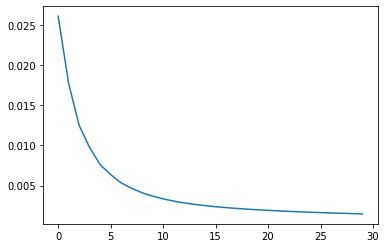

In [27]:
plt.plot(tr_loss_hist)

## many to one stacking

In [28]:
# example data
sentences = ['What I cannot create, I do not understand.',
             'Intellecuals solve problems, geniuses prevent them',
             'A person who never made a mistake never tied anything new.',
             'The same equations have the same solutions.']
y_data = [1,0,0,1] # 1: richard feynman, 0: albert einstein

In [32]:
char_set = [''] + sorted(list(set(''.join(sentences))))
idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

#print(char_set)
#print(idx2char)
print(char2idx)

{'': 0, ' ': 1, ',': 2, '.': 3, 'A': 4, 'I': 5, 'T': 6, 'W': 7, 'a': 8, 'b': 9, 'c': 10, 'd': 11, 'e': 12, 'g': 13, 'h': 14, 'i': 15, 'k': 16, 'l': 17, 'm': 18, 'n': 19, 'o': 20, 'p': 21, 'q': 22, 'r': 23, 's': 24, 't': 25, 'u': 26, 'v': 27, 'w': 28, 'y': 29}


In [33]:
# converting sequence of tokens to sequence of indices
x_data = list(map(lambda sentence : [char2idx.get(char) for char in sentence], sentences))
x_data_len = list(map(lambda sentence : len(sentence), sentences))

print(x_data)
#print(x_data_len)
#print(y_data)

[[7, 14, 8, 25, 1, 5, 1, 10, 8, 19, 19, 20, 25, 1, 10, 23, 12, 8, 25, 12, 2, 1, 5, 1, 11, 20, 1, 19, 20, 25, 1, 26, 19, 11, 12, 23, 24, 25, 8, 19, 11, 3], [5, 19, 25, 12, 17, 17, 12, 10, 26, 8, 17, 24, 1, 24, 20, 17, 27, 12, 1, 21, 23, 20, 9, 17, 12, 18, 24, 2, 1, 13, 12, 19, 15, 26, 24, 12, 24, 1, 21, 23, 12, 27, 12, 19, 25, 1, 25, 14, 12, 18], [4, 1, 21, 12, 23, 24, 20, 19, 1, 28, 14, 20, 1, 19, 12, 27, 12, 23, 1, 18, 8, 11, 12, 1, 8, 1, 18, 15, 24, 25, 8, 16, 12, 1, 19, 12, 27, 12, 23, 1, 25, 15, 12, 11, 1, 8, 19, 29, 25, 14, 15, 19, 13, 1, 19, 12, 28, 3], [6, 14, 12, 1, 24, 8, 18, 12, 1, 12, 22, 26, 8, 25, 15, 20, 19, 24, 1, 14, 8, 27, 12, 1, 25, 14, 12, 1, 24, 8, 18, 12, 1, 24, 20, 17, 26, 25, 15, 20, 19, 24, 3]]


In [35]:
# padding the sequence of indices
max_sequence = 55
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence,
                       padding = 'post', truncating = 'post')
#truncating= 값이 n개 이상일경우 뒤에 값 삭제

# checking data
print(x_data)
#print(x_data_len)
#print(y_data)

[[ 7 14  8 25  1  5  1 10  8 19 19 20 25  1 10 23 12  8 25 12  2  1  5  1
  11 20  1 19 20 25  1 26 19 11 12 23 24 25  8 19 11  3  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 5 19 25 12 17 17 12 10 26  8 17 24  1 24 20 17 27 12  1 21 23 20  9 17
  12 18 24  2  1 13 12 19 15 26 24 12 24  1 21 23 12 27 12 19 25  1 25 14
  12 18  0  0  0  0  0]
 [ 4  1 21 12 23 24 20 19  1 28 14 20  1 19 12 27 12 23  1 18  8 11 12  1
   8  1 18 15 24 25  8 16 12  1 19 12 27 12 23  1 25 15 12 11  1  8 19 29
  25 14 15 19 13  1 19]
 [ 6 14 12  1 24  8 18 12  1 12 22 26  8 25 15 20 19 24  1 14  8 27 12  1
  25 14 12  1 24  8 18 12  1 24 20 17 26 25 15 20 19 24  3  0  0  0  0  0
   0  0  0  0  0  0  0]]


In [37]:
# creating stacked rnn for "many to one" classification with dropout
num_classes = 2
hidden_dims = [10,10]

input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))

model = Sequential()
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                           trainable=False, mask_zero=True, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.SimpleRNN(units=hidden_dims[0], return_sequences=True))
model.add(layers.TimeDistributed(layers.Dropout(rate = .2)))
model.add(layers.SimpleRNN(units=hidden_dims[1]))
model.add(layers.Dropout(rate = .2))
model.add(layers.Dense(units=num_classes))

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 55, 30)            900       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 55, 10)            410       
                                                                 
 time_distributed (TimeDistr  (None, 55, 10)           0         
 ibuted)                                                         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                      

## many to many

In [39]:
# example data
sentences = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
pos = [['pronoun', 'verb', 'adjective'],
     ['noun', 'verb', 'adverb', 'adjective'],
     ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
     ['noun', 'verb', 'adverb', 'adjective', 'verb']]

In [41]:
# creating a token dictionary for word
word_list = sum(sentences, [])
word_list = sorted(set(word_list))
word_list = [''] + word_list
word2idx = {word : idx for idx, word in enumerate(word_list)}
idx2word = {idx : word for idx, word in enumerate(word_list)}

#print(word2idx)
print(idx2word)
#print(len(idx2word))

{0: '', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}


In [43]:
# creating a token dictionary for part of speech
pos_list = sum(pos, [])
pos_list = sorted(set(pos_list))
pos_list = [''] + pos_list
pos2idx = {pos : idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx : pos for idx, pos in enumerate(pos_list)}

#print(pos2idx)
print(idx2pos)
#print(len(pos2idx))

{0: '', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}


In [44]:
# converting sequence of tokens to sequence of indices
max_sequence = 10
x_data = list(map(lambda sentence : [word2idx.get(token) for token in sentence], sentences))
y_data = list(map(lambda sentence : [pos2idx.get(token) for token in sentence], pos))

# padding the sequence of indices
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence, padding='post')
x_data_mask = ((x_data != 0) * 1).astype(np.float32)
x_data_len = list(map(lambda sentence : len(sentence), sentences))

y_data = pad_sequences(sequences = y_data, maxlen = max_sequence, padding='post')

# checking data
print(x_data, x_data_len)
#print(x_data_mask)
#print(y_data)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]] [3, 4, 7, 5]


In [45]:
# creating rnn for "many to many" sequence tagging
num_classes = len(pos2idx)
hidden_dim = 10

input_dim = len(word2idx)
output_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

model = Sequential()
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True,
                           trainable=False, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.SimpleRNN(units=hidden_dim, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(units=num_classes)))

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 15)            225       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 10, 10)            260       
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 8)            88        
 tributed)                                                       
                                                                 
Total params: 573
Trainable params: 348
Non-trainable params: 225
_________________________________________________________________


In [47]:
# creating loss function
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    valid_time_step = tf.cast(x_len,dtype=tf.float32)    
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True) * masking    
    sequence_loss = tf.reduce_sum(sequence_loss, axis=-1) / valid_time_step    
    sequence_loss = tf.reduce_mean(sequence_loss)    
    return sequence_loss

# creating and optimizer
lr = 0.1
epochs = 30
batch_size = 2 
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [48]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size = 2)

print(tr_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [49]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb, x_mb_len in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, x_len=x_mb_len, max_sequence=max_sequence)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   5, tr_loss : 0.108
epoch :  10, tr_loss : 0.006
epoch :  15, tr_loss : 0.002
epoch :  20, tr_loss : 0.001
epoch :  25, tr_loss : 0.000
epoch :  30, tr_loss : 0.000


In [52]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
%matplotlib inline

In [54]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1) * x_data_mask

pprint(list(map(lambda row : [idx2pos.get(elm) for elm in row],yhat.astype(np.int32).tolist())), width = 120)
pprint(pos)

1/1 [==============================] - 0s 15ms/step
[['pronoun', 'verb', 'adjective', '', '', '', '', '', '', ''],
 ['noun', 'verb', 'adverb', 'adjective', '', '', '', '', '', ''],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun', '', '', ''],
 ['noun', 'verb', 'adverb', 'adjective', 'verb', '', '', '', '', '']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


## many to many bidirectional
- model 안에 bidirectional

In [55]:
# creating rnn for "many to many" sequence tagging
num_classes = len(pos2idx)
hidden_dim = 10

input_dim = len(word2idx)
output_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

model = Sequential()
model.add(layers.InputLayer(input_shape=(max_sequence,)))
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True,
                           trainable=False, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.Bidirectional(keras.layers.SimpleRNN(units=hidden_dim, return_sequences=True)))
model.add(layers.TimeDistributed(layers.Dense(units=num_classes)))

## seq2seq

In [56]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

from matplotlib import font_manager, rc

rc('font', family='AppleGothic') #for mac

import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pprint import pprint
import numpy as np
import os


In [57]:
sources = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
targets = [['나는', '배가', '고프다'],
           ['텐서플로우는', '매우', '어렵다'],
           ['텐서플로우는', '딥러닝을', '위한', '프레임워크이다'],
           ['텐서플로우는', '매우', '빠르게', '변화한다']]

In [59]:
# vocabulary for sources
s_vocab = list(set(sum(sources, [])))
s_vocab.sort()
s_vocab = [''] + s_vocab
source2idx = {word : idx for idx, word in enumerate(s_vocab)}
idx2source = {idx : word for idx, word in enumerate(s_vocab)}

#pprint(source2idx)
pprint(idx2source)

{0: '',
 1: 'I',
 2: 'a',
 3: 'changing',
 4: 'deep',
 5: 'difficult',
 6: 'fast',
 7: 'feel',
 8: 'for',
 9: 'framework',
 10: 'hungry',
 11: 'is',
 12: 'learning',
 13: 'tensorflow',
 14: 'very'}


In [61]:
# vocabulary for targets
t_vocab = list(set(sum(targets, [])))
t_vocab.sort()
t_vocab = ['', '', ''] + t_vocab
target2idx = {word : idx for idx, word in enumerate(t_vocab)}
idx2target = {idx : word for idx, word in enumerate(t_vocab)}

pprint(target2idx)
pprint(idx2target)

{'': 2,
 '고프다': 3,
 '나는': 4,
 '딥러닝을': 5,
 '매우': 6,
 '배가': 7,
 '변화한다': 8,
 '빠르게': 9,
 '어렵다': 10,
 '위한': 11,
 '텐서플로우는': 12,
 '프레임워크이다': 13}
{0: '',
 1: '',
 2: '',
 3: '고프다',
 4: '나는',
 5: '딥러닝을',
 6: '매우',
 7: '배가',
 8: '변화한다',
 9: '빠르게',
 10: '어렵다',
 11: '위한',
 12: '텐서플로우는',
 13: '프레임워크이다'}


In [62]:
def preprocess(sequences, max_len, dic, mode = 'source'):
    assert mode in ['source', 'target'], 'source와 target 중에 선택해주세요.'
    
    if mode == 'source':
        # preprocessing for source (encoder)
        s_input = list(map(lambda sentence : [dic.get(token) for token in sentence], sequences))
        s_len = list(map(lambda sentence : len(sentence), s_input))
        s_input = pad_sequences(sequences = s_input, maxlen = max_len, padding = 'post', truncating = 'post')
        return s_len, s_input
    
    elif mode == 'target':
        # preprocessing for target (decoder)
        # input
        t_input = list(map(lambda sentence : [''] + sentence + [''], sequences))
        t_input = list(map(lambda sentence : [dic.get(token) for token in sentence], t_input))
        t_len = list(map(lambda sentence : len(sentence), t_input))
        t_input = pad_sequences(sequences = t_input, maxlen = max_len, padding = 'post', truncating = 'post')
        
        # output
        t_output = list(map(lambda sentence : sentence + [''], sequences))
        t_output = list(map(lambda sentence : [dic.get(token) for token in sentence], t_output))
        t_output = pad_sequences(sequences = t_output, maxlen = max_len, padding = 'post', truncating = 'post')
        
        return t_len, t_input, t_output

In [65]:
# preprocessing for source
s_max_len = 10
s_len, s_input = preprocess(sequences = sources,
                            max_len = s_max_len, dic = source2idx, mode = 'source')
print(s_input)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]


In [67]:
# preprocessing for target
t_max_len = 12
t_len, t_input, t_output = preprocess(sequences = targets,
                                      max_len = t_max_len, dic = target2idx, mode = 'target')
print(t_input, t_output)

[[ 2  4  7  3  2  0  0  0  0  0  0  0]
 [ 2 12  6 10  2  0  0  0  0  0  0  0]
 [ 2 12  5 11 13  2  0  0  0  0  0  0]
 [ 2 12  6  9  8  2  0  0  0  0  0  0]] [[ 4  7  3  2  0  0  0  0  0  0  0  0]
 [12  6 10  2  0  0  0  0  0  0  0  0]
 [12  5 11 13  2  0  0  0  0  0  0  0]
 [12  6  9  8  2  0  0  0  0  0  0  0]]


In [68]:
# hyper-parameters
epochs = 200
batch_size = 4
learning_rate = .005
total_step = epochs / batch_size
buffer_size = 100
n_batch = buffer_size//batch_size
embedding_dim = 32
units = 32

# input
data = tf.data.Dataset.from_tensor_slices((s_len, s_input, t_len, t_input, t_output))
data = data.shuffle(buffer_size = buffer_size)
data = data.batch(batch_size = batch_size)
# s_mb_len, s_mb_input, t_mb_len, t_mb_input, t_mb_output = iterator.get_next()

In [69]:
def gru(units):
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_initializer='glorot_uniform')

In [70]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [71]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
                
    def call(self, x, hidden, enc_output):
        
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [72]:
encoder = Encoder(len(source2idx), embedding_dim, units, batch_size)
decoder = Decoder(len(target2idx), embedding_dim, units, batch_size)

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    
#     print("real: {}".format(real))
#     print("pred: {}".format(pred))
#     print("mask: {}".format(mask))
#     print("loss: {}".format(tf.reduce_mean(loss_)))
    
    return tf.reduce_mean(loss_)

# creating optimizer
optimizer = tf.keras.optimizers.Adam()

# creating check point (Object-based saving)
checkpoint_dir = './data_out/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                encoder=encoder,
                                decoder=decoder)

# create writer for tensorboard
#summary_writer = tf.summary.create_file_writer(logdir=checkpoint_dir)

In [76]:
for epoch in range(epochs):
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for i, (s_len, s_input, t_len, t_input, t_output) in enumerate(data):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(s_input, hidden)

            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([target2idx['']] * batch_size, 1)
            
            #Teacher Forcing: feeding the target as the next input
            for t in range(1, t_input.shape[1]):
                
                predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(t_input[:, t], predictions)
            
                dec_input = tf.expand_dims(t_input[:, t], 1) #using teacher forcing
                
        batch_loss = (loss / int(t_input.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradient = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradient, variables))
        
    if epoch % 10 == 0:
        #save model every 10 epoch
        print('Epoch {} Loss {:.4f} Batch Loss {:.4f}'.format(epoch,
                                            total_loss / n_batch,
                                            batch_loss.numpy()))
        checkpoint.save(file_prefix = checkpoint_prefix)

InvalidArgumentError: Received a label value of 12 which is outside the valid range of [0, 12).  Label values: 4 12 12 12 [Op:SparseSoftmaxCrossEntropyWithLogits]